<a href="https://colab.research.google.com/github/Baraa-Rayed/ECG-Arrhythmia-Classification/blob/main/ECG_Arrhythmia_Classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
import glob
from tensorflow.keras.preprocessing import image

Loading MIT-BIH Databasse

In [ ]:
!pip install wfdb wget

In [ ]:
import os
import wfdb
wfdb.dl_database('ludb', os.path.join(os.getcwd(), 'ludb'))

In [ ]:
import os
import wfdb
wfdb.dl_database('mitdb', os.path.join(os.getcwd(), 'mitdb'))

In [ ]:
import glob
import re
import os
from pathlib import Path
name = []
ecg_path = glob.glob('/content/mitdb/*.hea')
for i in list(ecg_path):
  if i.endswith('.hea'):
    match = re.search(r'\d+', os.path.splitext(i)[0])
    if match:
      number = match.group()
    print(number)
#   z = i[-7:-4]
#   name.append(z)
# print(name)

In [ ]:
for i in list(ecg_path):
  record = wfdb.rdrecord(f'{i[:-4]}', sampto=3000)
  annotation = wfdb.rdann(f'{i[:-4]}', 'avf', sampto=1000)
  wfdb.plot_wfdb(record=record, annotation=annotation, plot_sym=True,
                  time_units='seconds', title='MIT-BIH Record 234',
                  figsize=(10,4), ecg_grids='all')

In [ ]:
from sklearn.preprocessing import scale
import numpy as np
import matplotlib.pyplot as plt
import cv2
import os.path as osp
for i in list(ecg_path):
  z = i[-7:-4]
  names = osp.basename(z)
mode = 128
image_size = (128,128)
output = "/content/drive/MyDrive/mitdb_data"
def plot(signal, filename):
    plt.figure(figsize=(12,8), frameon=False)
    plt.axis("off")
    plt.subplots_adjust(top=1, bottom=0, right=1, left=0, hspace=0, wspace=0)
    # plt.margins(0, 0) # use for generation images with no margin
    plt.plot(signal)
    plt.savefig(filename)

    plt.close()

    im_gray = cv2.imread(filename, cv2.IMREAD_GRAYSCALE)
    im_gray = cv2.resize(im_gray, image_size, interpolation=cv2.INTER_LANCZOS4)
    cv2.imwrite(filename, im_gray)
for i in list(ecg_path):
  z = i[-7:-4]
  names = osp.basename(z)
  record = wfdb.rdrecord(f'{i[:-4]}', sampto=3000)
  annotation = wfdb.rdann(f'{i[:-4]}', 'atr', sampto=3000)
  for sig_name, signal in zip(record.sig_name, record.p_signal.T):
        if not np.all(np.isfinite(signal)):
            continue
        signal = scale(signal)
        for i, (label, peak) in enumerate(zip(annotation.symbol, annotation.sample)):
            if label == "/":
                label = "\\"
            print("\r{} [{}/{}]".format(sig_name, i + 1, len(annotation.symbol)), end="")
            if isinstance(mode, list):
                if np.all([i > 0, i + 1 < len(annotation.sample)]):
                    left = annotation.sample[i - 1] + mode[0]
                    right = annotation.sample[i + 1] - mode[1]
                else:
                    continue
            elif isinstance(mode, int):
                left, right = peak - mode // 2, peak + mode // 2
            else:
                raise Exception("Wrong mode in script beginning")
            if np.all([left > 0, right < len(signal)]):
                one_dim_data_dir = osp.join(output, "1D", names, sig_name, label)
                two_dim_data_dir = osp.join(output, "2D", names, sig_name, label)

                os.makedirs(one_dim_data_dir, exist_ok=True)
                os.makedirs(two_dim_data_dir, exist_ok=True)

                filename = osp.join(one_dim_data_dir, "{}.npy".format(peak))
                np.save(filename, signal[left:right])
                filename = osp.join(two_dim_data_dir, "{}.png".format(peak))

                plot(signal[left:right], filename)

V1 [10/10]

In [ ]:
import json
import os.path as osp
from glob import glob

import pandas as pd

# 1. N - Normal
# 2. V - PVC (Premature ventricular contraction)
# 3. \ - PAB (Paced beat)
# 4. R - RBB (Right bundle branch)
# 5. L - LBB (Left bundle branch)
# 6. A - APB (Atrial premature beat)
# 7. ! - AFW (Ventricular flutter wave)
# 8. E - VEB (Ventricular escape beat)

classes = ["N", "V", "\\", "R", "L", "A", "!", "E"]
lead = "MLII"
extension = "png"  # or `npy` for 1D
data_path = osp.abspath("/content/drive/MyDrive/mitdb_data/*/*/*/*/*.{}".format(extension))
val_size = 0.1  # [0, 1]

output_path = "/".join(data_path.split("/")[:-5])

random_state = 7

dataset = []
files = glob(data_path)

for file in glob(data_path):
    *_, name, lead, label, filename = file.split("/")
    dataset.append(
        {
            "name": name,
            "lead": lead,
            "label": label,
            "filename": osp.splitext(filename)[0],
            "path": file,
        },
    )


data = pd.DataFrame(dataset)
data = data[data["lead"] == lead]
data = data[data["label"].isin(classes)]
data = data.sample(frac=1, random_state=random_state)

val_ids = []
for cl in classes:
    val_ids.extend(
        data[data["label"] == cl]
        .sample(frac=val_size, random_state=random_state)
        .index,
    )

val = data.loc[val_ids, :]
train = data[~data.index.isin(val.index)]

train.to_json(osp.join(output_path, "train.json"), orient="records")
val.to_json(osp.join(output_path, "val.json"), orient="records")

d = {}
for label in train.label.unique():
    d[label] = len(d)

with open(osp.join(output_path, "class-mapper.json"), "w") as file:
    file.write(json.dumps(d, indent=1))

In [ ]:
import os
import os.path as osp
from glob import glob
import pandas as pd
import seaborn as sns

from sklearn.model_selection import train_test_split
from pylab import rcParams
import json
import matplotlib.pyplot as plt

rcParams['figure.figsize'] = 8, 5
train = pd.read_json('/content/drive/MyDrive/mitdb_data/train.json')
val = pd.read_json('/content/drive/MyDrive/mitdb_data/val.json')
mapping = json.load(open('/content/drive/MyDrive/mitdb_data/class-mapper.json'))

train.head()

,name,lead,label,filename,path
0,105,V1,N,197,/content/drive/MyDrive/mitdb_data/2D/105/V1/N/...
1,112,V1,N,1393,/content/drive/MyDrive/mitdb_data/2D/112/V1/N/...
2,116,V1,N,1909,/content/drive/MyDrive/mitdb_data/2D/116/V1/N/...
3,221,V1,V,2520,/content/drive/MyDrive/mitdb_data/2D/221/V1/V/...
4,105,V1,N,2015,/content/drive/MyDrive/mitdb_data/2D/105/V1/N/...


In [ ]:
val.head()

,name,lead,label,filename,path
0,234,V1,N,366,/content/drive/MyDrive/mitdb_data/2D/234/V1/N/...
1,121,V1,N,513,/content/drive/MyDrive/mitdb_data/2D/121/V1/N/...
2,113,V1,N,966,/content/drive/MyDrive/mitdb_data/2D/113/V1/N/...
3,119,V1,N,1971,/content/drive/MyDrive/mitdb_data/2D/119/V1/N/...
4,105,V1,N,1741,/content/drive/MyDrive/mitdb_data/2D/105/V1/N/...


In [ ]:
y = train['label']
x = train['path']

In [ ]:
import cv2

In [ ]:
base_dir = '/content/drive/MyDrive/mitdb_data/'
trainnig = '/content/drive/MyDrive/mitdb_data/training'
# os.makedirs(osp.join(base_dir,'training'))
# normal_dir = os.makedirs(osp.join(trainnig,'Normal'))



In [ ]:
os.makedirs(osp.join(base_dir,'validation'))

In [ ]:
import os.path as osp

In [ ]:
normal_dir = os.makedirs(osp.join(trainnig,'Normal'))
PVC_dir = os.makedirs(osp.join(trainnig,'PVC'))
PAB_dir = os.makedirs(osp.join(trainnig,'PAB'))
RBB_dir = os.makedirs(osp.join(trainnig,'RBB'))
LBB_dir = os.makedirs(osp.join(trainnig,'LBB'))
APB_dir = os.makedirs(osp.join(trainnig,'APB'))
AFW_dir = os.makedirs(osp.join(trainnig,'AFW'))
VEB_dir = os.makedirs(osp.join(trainnig,'VEB'))

FileExistsError: ignored

In [ ]:
validation = '/content/drive/MyDrive/mitdb_data/validation'
normal_dir = os.makedirs(osp.join(validation,'Normal'))
PVC_dir = os.makedirs(osp.join(validation,'PVC'))
PAB_dir = os.makedirs(osp.join(validation,'PAB'))
RBB_dir = os.makedirs(osp.join(validation,'RBB'))
LBB_dir = os.makedirs(osp.join(validation,'LBB'))
APB_dir = os.makedirs(osp.join(validation,'APB'))
AFW_dir = os.makedirs(osp.join(validation,'AFW'))
VEB_dir = os.makedirs(osp.join(validation,'VEB'))

In [ ]:
Split_Params_For_LABEL = "mitdb_data/2D/"
Common_Params = "/"
for label_x in list(train["path"]):
   L_Main_Path,L_Target_Path = label_x.split(Split_Params_For_LABEL)
   Label_Path_Before,Label_Path_Middle,Label_Path_After,label_file = L_Target_Path.split(Common_Params)
   if Label_Path_After =='N':
     img = cv2.imread(label_x,0)
     cv2.imwrite(f'/content/drive/MyDrive/mitdb_data/training/Normal/{Label_Path_After}_{label_file}',img)
   if Label_Path_After =='V':
     img = cv2.imread(label_x,0)
     cv2.imwrite(f'/content/drive/MyDrive/mitdb_data/training/PVC/{Label_Path_After}_{label_file}',img)
   if Label_Path_After =='\\':
     img = cv2.imread(label_x,0)
     cv2.imwrite(f'/content/drive/MyDrive/mitdb_data/training/PAB/{Label_Path_After}_{label_file}',img)
   if Label_Path_After =='R':
     img = cv2.imread(label_x,0)
     cv2.imwrite(f'/content/drive/MyDrive/mitdb_data/training/RBB/{Label_Path_After}_{label_file}',img)
   if Label_Path_After =='L':
     img = cv2.imread(label_x,0)
     cv2.imwrite(f'/content/drive/MyDrive/mitdb_data/training/LBB/{Label_Path_After}_{label_file}',img)
   if Label_Path_After =='A':
     img = cv2.imread(label_x,0)
     cv2.imwrite(f'/content/drive/MyDrive/mitdb_data/training/APB/{Label_Path_After}_{label_file}',img)
   if Label_Path_After =='!':
     img = cv2.imread(label_x,0)
     cv2.imwrite(f'/content/drive/MyDrive/mitdb_data/training/AFW/{Label_Path_After}_{label_file}',img)
   if Label_Path_After =='E':
     img = cv2.imread(label_x,0)
     cv2.imwrite(f'/content/drive/MyDrive/mitdb_data/training/VEB/{Label_Path_After}_{label_file}',img)

In [ ]:
validation = '/content/drive/MyDrive/mitdb_data/validation'
Split_Params_For_LABEL = "mitdb_data/2D/"
Common_Params = "/"
for label_x in list(val["path"]):
   L_Main_Path,L_Target_Path = label_x.split(Split_Params_For_LABEL)
   Label_Path_Before,Label_Path_Middle,Label_Path_After,label_file = L_Target_Path.split(Common_Params)
   if Label_Path_After =='N':
     img = cv2.imread(label_x,0)
     cv2.imwrite(f'/content/drive/MyDrive/mitdb_data/validation/Normal/{Label_Path_After}_{label_file}',img)
   if Label_Path_After =='V':
     img = cv2.imread(label_x,0)
     cv2.imwrite(f'/content/drive/MyDrive/mitdb_data/validation/PVC/{Label_Path_After}_{label_file}',img)
   if Label_Path_After =='\\':
     img = cv2.imread(label_x,0)
     cv2.imwrite(f'/content/drive/MyDrive/mitdb_data/validation/PAB/{Label_Path_After}_{label_file}',img)
   if Label_Path_After =='R':
     img = cv2.imread(label_x,0)
     cv2.imwrite(f'/content/drive/MyDrive/mitdb_data/validation/RBB/{Label_Path_After}_{label_file}',img)
   if Label_Path_After =='L':
     img = cv2.imread(label_x,0)
     cv2.imwrite(f'/content/drive/MyDrive/mitdb_data/validation/LBB/{Label_Path_After}_{label_file}',img)
   if Label_Path_After =='A':
     img = cv2.imread(label_x,0)
     cv2.imwrite(f'/content/drive/MyDrive/mitdb_data/validation/APB/{Label_Path_After}_{label_file}',img)
   if Label_Path_After =='!':
     img = cv2.imread(label_x,0)
     cv2.imwrite(f'/content/drive/MyDrive/mitdb_data/validation/AFW/{Label_Path_After}_{label_file}',img)
   if Label_Path_After =='E':
     img = cv2.imread(label_x,0)
     cv2.imwrite(f'/content/drive/MyDrive/mitdb_data/validation/VEB/{Label_Path_After}_{label_file}',img)

In [ ]:
SIZE = 200
X_dataset = []
for i in list(x):
    img = image.load_img(i, target_size=(SIZE,SIZE,3))
    img = image.img_to_array(img)
    img = img/255.
    X_dataset.append(img)

In [ ]:
import numpy as np
X = np.array(X_dataset)

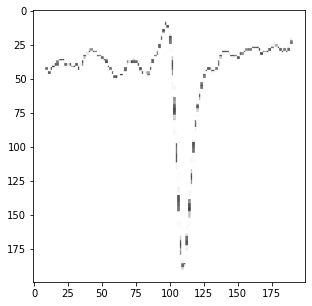

In [ ]:
import matplotlib.pyplot as plt
plt.imshow(X[50])

In [ ]:
X.shape
y.shape

(378,)

In [ ]:
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

In [ ]:
img_width=200; img_height=200
batch_size=16
TRAINING_DIR = '/content/drive/MyDrive/mitdb_data/training/'

train_datagen = ImageDataGenerator(rescale = 1/255.0,
                                   rotation_range=30,
                                   zoom_range=0.4,
                                   horizontal_flip=True)

train_generator = train_datagen.flow_from_directory(TRAINING_DIR,
                                                    batch_size=batch_size,
                                                    class_mode='categorical',
                                                    target_size=(img_height, img_width))


Found 369 images belonging to 8 classes.


In [ ]:

VALIDATION_DIR = '/content/drive/MyDrive/mitdb_data/validation'

validation_datagen = ImageDataGenerator(rescale = 1/255.0)

validation_generator = validation_datagen.flow_from_directory(VALIDATION_DIR,
                                                              batch_size=batch_size,
                                                              class_mode='categorical',
                                                              target_size=(img_height, img_width)
                                                             )

Found 42 images belonging to 8 classes.


In [ ]:
validation_generator.class_indices

{'AFW': 0,
 'APB': 1,
 'LBB': 2,
 'Normal': 3,
 'PAB': 4,
 'PVC': 5,
 'RBB': 6,
 'VEB': 7}

In [ ]:
callbacks = EarlyStopping(monitor='val_loss', patience=5, verbose=1, mode='auto')
# autosave best Model
best_model_file = '/content/CNN_aug_best_weights.h5'
best_model = ModelCheckpoint(best_model_file, monitor='val_acc', verbose = 1, save_best_only = True)

In [ ]:
import tensorflow as tf
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.layers import Dense, Flatten
from tensorflow.keras.models import Sequential

# Load the VGG16 model
vgg16 = VGG16(weights='imagenet', include_top=False, input_shape=(200, 200, 3))

# Freeze the layers of the model
for layer in vgg16.layers:
    layer.trainable = False

# Create a new model on top of the VGG16 model
model = Sequential()
model.add(vgg16)
model.add(Flatten())
model.add(Dense(512, activation='relu'))
model.add(Dense(units=8, activation='softmax'))
model.summary()


58889256/58889256 [==============================] - 0s 0us/step
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 6, 6, 512)         14714688  
                                                                 
 flatten (Flatten)           (None, 18432)             0         
                                                                 
 dense (Dense)               (None, 512)               9437696   
                                                                 
 dense_1 (Dense)             (None, 8)                 4104      
                                                                 
Total params: 24,156,488
Trainable params: 9,441,800
Non-trainable params: 14,714,688
_________________________________________________________________


In [ ]:
model.compile(optimizer='Adam',
              loss='categorical_crossentropy',
              metrics =['accuracy'])

In [ ]:

history = model.fit_generator(train_generator,
                              epochs=30,
                              verbose=1,
                              validation_data=validation_generator,
                              callbacks = [best_model]
                              )

<ipython-input-32-5368c251678d>:1: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = model.fit_generator(train_generator,


Epoch 1/30
24/24 [==============================] - ETA: 0s - loss: 2.8494 - accuracy: 0.6504

24/24 [==============================] - 236s 10s/step - loss: 2.8494 - accuracy: 0.6504 - val_loss: 0.8804 - val_accuracy: 0.7857
Epoch 2/30
24/24 [==============================] - ETA: 0s - loss: 0.7981 - accuracy: 0.7724

24/24 [==============================] - 213s 9s/step - loss: 0.7981 - accuracy: 0.7724 - val_loss: 0.7506 - val_accuracy: 0.7857
Epoch 3/30
24/24 [==============================] - ETA: 0s - loss: 0.7637 - accuracy: 0.7507

24/24 [==============================] - 213s 9s/step - loss: 0.7637 - accuracy: 0.7507 - val_loss: 0.8770 - val_accuracy: 0.7619
Epoch 4/30
24/24 [==============================] - ETA: 0s - loss: 0.8038 - accuracy: 0.7507

24/24 [==============================] - 214s 9s/step - loss: 0.8038 - accuracy: 0.7507 - val_loss: 0.5869 - val_accuracy: 0.7619
Epoch 5/30
24/24 [==============================] - ETA: 0s - loss: 0.6216 - accuracy: 0.7967

24/24 [==============================] - 233s 10s/step - loss: 0.6216 - accuracy: 0.7967 - val_loss: 0.5074 - val_accuracy: 0.8333
Epoch 6/30
24/24 [==============================] - ETA: 0s - loss: 0.4706 - accuracy: 0.8238

24/24 [==============================] - 232s 10s/step - loss: 0.4706 - accuracy: 0.8238 - val_loss: 0.4426 - val_accuracy: 0.8333
Epoch 7/30
24/24 [==============================] - ETA: 0s - loss: 0.4246 - accuracy: 0.8591

24/24 [==============================] - 232s 10s/step - loss: 0.4246 - accuracy: 0.8591 - val_loss: 0.3718 - val_accuracy: 0.8333
Epoch 8/30
24/24 [==============================] - ETA: 0s - loss: 0.3883 - accuracy: 0.8591

24/24 [==============================] - 229s 10s/step - loss: 0.3883 - accuracy: 0.8591 - val_loss: 0.3887 - val_accuracy: 0.8333
Epoch 9/30
24/24 [==============================] - ETA: 0s - loss: 0.3842 - accuracy: 0.8835

24/24 [==============================] - 213s 9s/step - loss: 0.3842 - accuracy: 0.8835 - val_loss: 0.3206 - val_accuracy: 0.8333
Epoch 10/30
24/24 [==============================] - ETA: 0s - loss: 0.4013 - accuracy: 0.8591

24/24 [==============================] - 233s 10s/step - loss: 0.4013 - accuracy: 0.8591 - val_loss: 0.3078 - val_accuracy: 0.8810
Epoch 11/30
24/24 [==============================] - ETA: 0s - loss: 0.4179 - accuracy: 0.8537

24/24 [==============================] - 215s 9s/step - loss: 0.4179 - accuracy: 0.8537 - val_loss: 0.5772 - val_accuracy: 0.8333
Epoch 12/30
24/24 [==============================] - ETA: 0s - loss: 0.5685 - accuracy: 0.8645

24/24 [==============================] - 234s 10s/step - loss: 0.5685 - accuracy: 0.8645 - val_loss: 0.5377 - val_accuracy: 0.8333
Epoch 13/30
24/24 [==============================] - ETA: 0s - loss: 0.3589 - accuracy: 0.8618

24/24 [==============================] - 233s 10s/step - loss: 0.3589 - accuracy: 0.8618 - val_loss: 0.4805 - val_accuracy: 0.8333
Epoch 14/30
24/24 [==============================] - ETA: 0s - loss: 0.4666 - accuracy: 0.8238

24/24 [==============================] - 233s 10s/step - loss: 0.4666 - accuracy: 0.8238 - val_loss: 0.3812 - val_accuracy: 0.8810
Epoch 15/30
24/24 [==============================] - ETA: 0s - loss: 0.3672 - accuracy: 0.8753

24/24 [==============================] - 233s 10s/step - loss: 0.3672 - accuracy: 0.8753 - val_loss: 0.4169 - val_accuracy: 0.8571
Epoch 16/30
24/24 [==============================] - ETA: 0s - loss: 0.3710 - accuracy: 0.8672

24/24 [==============================] - 233s 10s/step - loss: 0.3710 - accuracy: 0.8672 - val_loss: 0.2323 - val_accuracy: 0.9286
Epoch 17/30
24/24 [==============================] - ETA: 0s - loss: 0.6979 - accuracy: 0.7724

24/24 [==============================] - 214s 9s/step - loss: 0.6979 - accuracy: 0.7724 - val_loss: 0.3244 - val_accuracy: 0.9048
Epoch 18/30
24/24 [==============================] - ETA: 0s - loss: 0.5087 - accuracy: 0.8455

24/24 [==============================] - 229s 10s/step - loss: 0.5087 - accuracy: 0.8455 - val_loss: 0.3313 - val_accuracy: 0.9048
Epoch 19/30
24/24 [==============================] - ETA: 0s - loss: 0.3280 - accuracy: 0.8835

24/24 [==============================] - 214s 9s/step - loss: 0.3280 - accuracy: 0.8835 - val_loss: 0.3124 - val_accuracy: 0.8333
Epoch 20/30
24/24 [==============================] - ETA: 0s - loss: 0.3193 - accuracy: 0.8808

24/24 [==============================] - 232s 10s/step - loss: 0.3193 - accuracy: 0.8808 - val_loss: 0.2616 - val_accuracy: 0.8571
Epoch 21/30
24/24 [==============================] - ETA: 0s - loss: 0.3520 - accuracy: 0.8591

24/24 [==============================] - 217s 9s/step - loss: 0.3520 - accuracy: 0.8591 - val_loss: 0.2688 - val_accuracy: 0.8571
Epoch 22/30
24/24 [==============================] - ETA: 0s - loss: 0.3031 - accuracy: 0.8997

24/24 [==============================] - 214s 9s/step - loss: 0.3031 - accuracy: 0.8997 - val_loss: 0.2188 - val_accuracy: 0.9048
Epoch 23/30
24/24 [==============================] - ETA: 0s - loss: 0.2870 - accuracy: 0.9051

24/24 [==============================] - 219s 9s/step - loss: 0.2870 - accuracy: 0.9051 - val_loss: 0.2126 - val_accuracy: 0.9524
Epoch 24/30
24/24 [==============================] - ETA: 0s - loss: 0.3024 - accuracy: 0.8699

24/24 [==============================] - 212s 9s/step - loss: 0.3024 - accuracy: 0.8699 - val_loss: 0.2122 - val_accuracy: 0.9286
Epoch 25/30
24/24 [==============================] - ETA: 0s - loss: 0.2709 - accuracy: 0.9024

24/24 [==============================] - 231s 10s/step - loss: 0.2709 - accuracy: 0.9024 - val_loss: 0.1624 - val_accuracy: 0.9762
Epoch 26/30
24/24 [==============================] - ETA: 0s - loss: 0.2507 - accuracy: 0.9187

24/24 [==============================] - 211s 9s/step - loss: 0.2507 - accuracy: 0.9187 - val_loss: 0.1849 - val_accuracy: 0.9048
Epoch 27/30
24/24 [==============================] - ETA: 0s - loss: 0.2640 - accuracy: 0.9051

24/24 [==============================] - 231s 10s/step - loss: 0.2640 - accuracy: 0.9051 - val_loss: 0.3904 - val_accuracy: 0.8571
Epoch 28/30
24/24 [==============================] - ETA: 0s - loss: 0.3247 - accuracy: 0.8753

24/24 [==============================] - 229s 10s/step - loss: 0.3247 - accuracy: 0.8753 - val_loss: 0.2927 - val_accuracy: 0.9048
Epoch 29/30
24/24 [==============================] - ETA: 0s - loss: 0.3826 - accuracy: 0.8564

24/24 [==============================] - 211s 9s/step - loss: 0.3826 - accuracy: 0.8564 - val_loss: 0.1831 - val_accuracy: 0.9048
Epoch 30/30
24/24 [==============================] - ETA: 0s - loss: 0.2373 - accuracy: 0.9079

24/24 [==============================] - 210s 9s/step - loss: 0.2373 - accuracy: 0.9079 - val_loss: 0.2077 - val_accuracy: 0.9286


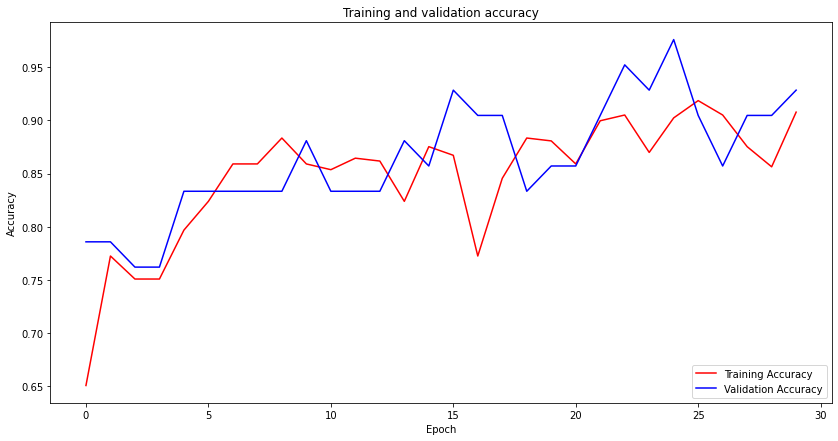

In [ ]:
acc=history.history['accuracy']
val_acc=history.history['val_accuracy']
loss=history.history['loss']
val_loss=history.history['val_loss']

epochs=range(len(acc))

fig = plt.figure(figsize=(14,7))
plt.plot(epochs, acc, 'r', label="Training Accuracy")
plt.plot(epochs, val_acc, 'b', label="Validation Accuracy")
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training and validation accuracy')
plt.legend(loc='lower right')
plt.show()

Text(0.5, 1.0, 'Training and validation loss')

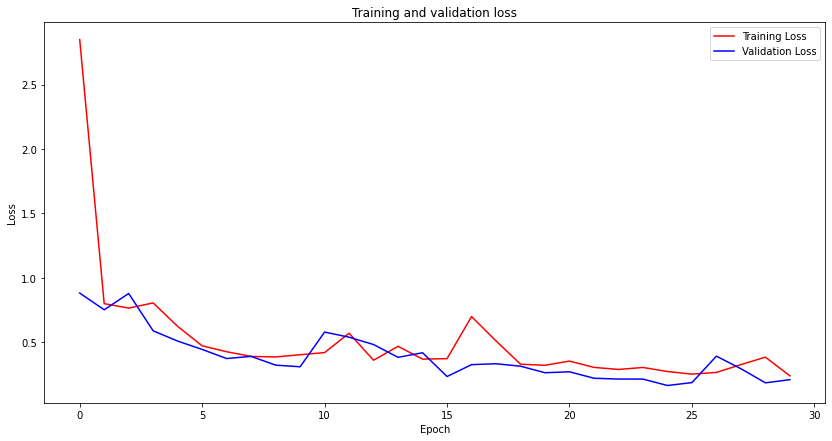

In [ ]:

fig2 = plt.figure(figsize=(14,7))
plt.plot(epochs, loss, 'r', label="Training Loss")
plt.plot(epochs, val_loss, 'b', label="Validation Loss")
plt.legend(loc='upper right')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and validation loss')

## Checking performance on Test Data (Out of the sample)

In [ ]:

## Test Performance on Test Data
import pandas as pd
import numpy as np
from tensorflow.keras.preprocessing.image import load_img, img_to_array

def preprocess_image(path):
    img = load_img(path, target_size = (img_height, img_width))
    a = img_to_array(img)
    a = np.expand_dims(a, axis = 0)
    a /= 255.
    return a


In [ ]:
from pathlib import Path
from glob import glob
test_images_dir = Path('/content/drive/MyDrive/mitdb_data/validation')
test_df = pd.read_json('/content/drive/MyDrive/mitdb_data/val.json')

test_images =list(test_images_dir.glob(r"**/*.png"))
Image_Series = pd.Series(test_images,name="IMAGE").astype(str)

test_preprocessed_images = np.vstack([preprocess_image(fn) for fn in Image_Series])

In [ ]:
array = model.predict(test_preprocessed_images, batch_size=1, verbose=1)
answer = np.argmax(array, axis=1)
print(answer)


42/42 [==============================] - 21s 489ms/step
[3 3 3 3 3 2 3 3 3 3 3 3 3 3 3 3 2 3 3 3 3 3 3 3 3 3 3 3 2 3 5 5 5 4 4 6 6
 6 6 2 2 2]


## classroom

In [ ]:
ecg = record.p_signal

array([[-0.08 ,  0.135],
       [-0.08 ,  0.135],
       [-0.08 ,  0.135],
       ...,
       [ 0.92 ,  0.435],
       [ 0.625,  0.395],
       [ 0.33 ,  0.285]])

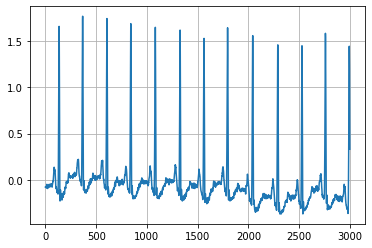

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
plt.plot(ecg[:,0])
plt.grid('on')

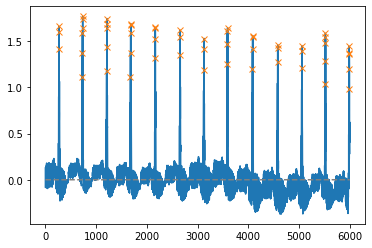

In [ ]:
from scipy.signal import find_peaks
ecg= ecg.flatten()
peaks, _ = find_peaks(ecg, threshold = 1)
plt.plot(ecg)
plt.plot(peaks, ecg[peaks], "x")
plt.plot(np.zeros_like(ecg), "--", color="gray")
plt.show()

Text(0.5, 0, 'Time (s)')

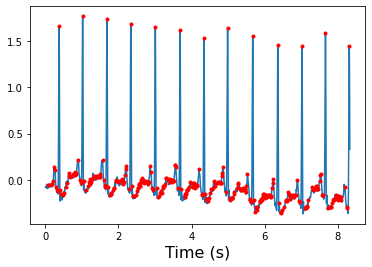

In [ ]:
ecg = record.p_signal
x = ecg[:,0]
fs= 360
thr = 0.6
rlist =[]
L = 3000
x2 = x[:L]
for i in range(1, len(x2)-1):
  if (x2[i-1]<x2[i]) and (x[i]>x2[i+1]):
    rlist.append(i)

t = np.arange(L)/fs
plt.plot(t,x2)
plt.plot([a/fs for a in rlist], x2[rlist],'r.')
plt.xlabel('Time (s)', fontsize = 16)

In [ ]:
from pathlib import Path
def get_records():
    """ Get paths for data in data/mit/ directory """
    #Download if doesn't exist

    # There are 3 files for each record
    # *.atr is one of them
    paths = glob.glob('/content/mitdb/*.atr')

    # Get rid of the extension
    paths = [path[:-1] for path in paths]
    paths.sort()
    return paths

In [ ]:
get_records()

['/content/mitdb/100.at',
 '/content/mitdb/101.at',
 '/content/mitdb/102.at',
 '/content/mitdb/103.at',
 '/content/mitdb/104.at',
 '/content/mitdb/105.at',
 '/content/mitdb/106.at',
 '/content/mitdb/107.at',
 '/content/mitdb/108.at',
 '/content/mitdb/109.at',
 '/content/mitdb/111.at',
 '/content/mitdb/112.at',
 '/content/mitdb/113.at',
 '/content/mitdb/114.at',
 '/content/mitdb/115.at',
 '/content/mitdb/116.at',
 '/content/mitdb/117.at',
 '/content/mitdb/118.at',
 '/content/mitdb/119.at',
 '/content/mitdb/121.at',
 '/content/mitdb/122.at',
 '/content/mitdb/123.at',
 '/content/mitdb/124.at',
 '/content/mitdb/200.at',
 '/content/mitdb/201.at',
 '/content/mitdb/202.at',
 '/content/mitdb/203.at',
 '/content/mitdb/205.at',
 '/content/mitdb/207.at',
 '/content/mitdb/208.at',
 '/content/mitdb/209.at',
 '/content/mitdb/210.at',
 '/content/mitdb/212.at',
 '/content/mitdb/213.at',
 '/content/mitdb/214.at',
 '/content/mitdb/215.at',
 '/content/mitdb/217.at',
 '/content/mitdb/219.at',
 '/content/m

In [ ]:
import wfdb #WaveForm-Database package. A library of tools for reading, writing, and processing WFDB signals and annotations.
import pandas as pd
import numpy as np
import glob


dat_files=glob.glob('/content/mitdb/*.dat') #Get list of all .dat files in the current folder
df=pd.DataFrame(data=dat_files)
df.to_csv("files_list.csv",index=False,header=None) #Write the list to a CSV file
files=pd.read_csv("files_list.csv",header=None)

for i in range(1,len(files)):
    recordname=str(files.iloc[[i]])
    print(recordname[:-4])
    recordname_new=recordname[-13:-4] #Extracting just the filename part (will differ from database to database)
    record = wfdb.rdsamp(recordname_new) # rdsamp() returns the signal as a numpy array
    record=np.asarray(record[0])
    path=recordname_new+".csv"
    np.savetxt(path,record,delimiter=",") #Writing the CSV for each record
    print("Files done: %s/%s"% (i,len(files)))

print("\nAll files done!")

                        0
1  /content/mitdb/113
Files done: 1/48
                        0
2  /content/mitdb/212
Files done: 2/48
                        0
3  /content/mitdb/233
Files done: 3/48
                        0
4  /content/mitdb/217
Files done: 4/48
                        0
5  /content/mitdb/121
Files done: 5/48
                        0
6  /content/mitdb/122
Files done: 6/48
                        0
7  /content/mitdb/111
Files done: 7/48
                        0
8  /content/mitdb/106
Files done: 8/48
                        0
9  /content/mitdb/223
Files done: 9/48
                         0
10  /content/mitdb/114
Files done: 10/48
                         0
11  /content/mitdb/201
Files done: 11/48
                         0
12  /content/mitdb/109
Files done: 12/48
                         0
13  /content/mitdb/203
Files done: 13/48
                         0
14  /content/mitdb/200
Files done: 14/48
                         0
15  /content/mitdb/123
Files done: 15/48
       

IndexError: ignored

In [ ]:
pip install biosppy

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 106 kB 20.4 MB/s 


In [ ]:
import biosppy
indices = []
path = glob.glob('/content/mitdb/*.csv')
kernel = np.ones((4,4),np.uint8)
signals = []
count = 1
for i in path:
  csv = pd.read_csv(i)
  csv_data = csv
  data = np.array(csv_data)


  peaks =  biosppy.signals.ecg.christov_segmenter(signal=data, sampling_rate = 200)[0]
for i in (peaks[1:-1]):
    diff1 = abs(peaks[count - 1] - i)
    diff2 = abs(peaks[count + 1]- i)
    x = peaks[count - 1] + diff1//2
    y = peaks[count + 1] - diff2//2
    signal = data[x:y]
    signals.append(signal)
    count += 1
    indices.append((x,y))


ValueError: ignored

In [ ]:
path = glob.glob('/content/mitdb/*.csv')
for i in path:
  csv = pd.read_csv(i)

In [ ]:
csv.head

<bound method NDFrame.head of         -3.750000000000000000e-01  5.000000000000000278e-02
0                          -0.375                     0.050
1                          -0.375                     0.050
2                          -0.375                     0.050
3                          -0.375                     0.050
4                          -0.375                     0.050
...                           ...                       ...
649994                     -0.200                     0.100
649995                     -0.225                     0.075
649996                     -0.235                     0.050
649997                     -0.245                     0.055
649998                      0.000                     0.000

[649999 rows x 2 columns]>

In [ ]:
#@title Default title text
import wfdb
import librosa
import numpy as np
import tensorflow as tf
from sklearn.model_selection import train_test_split

# Load ECG data using WFDB Toolbox
record = wfdb.rdrecord('filename') # replace 'filename' with the name of your ECG recording
signal = record.p_signal[:,0] # extract the first channel

# Load ECG annotations using WFDB Toolbox
annotations = wfdb.rdann('filename', 'atr') # replace 'filename' with the name of your ECG recording

# Define the classes and mapping from annotations to classes
classes = {
    'N': 0, # Normal beat
    'L': 1, # Left bundle branch block beat
    'R': 2, # Right bundle branch block beat
    'A': 3, # Atrial premature beat
    'V': 4, # Premature ventricular contraction
}
ann2class = {ann: classes.get(ann, 5) for ann in annotations.symbol}

# Preprocess the ECG data
signal_filt = librosa.effects.preemphasis(signal) # remove baseline drift
signal_filt = librosa.effects.trim(signal_filt)[0] # remove silent regions
signal_filt = librosa.util.normalize(signal_filt) # normalize to range [-1, 1]

# Divide the signal into smaller segments and label each segment
window_size = 2 * record.fs # 2-second windows
step_size = int(0.5 * window_size) # 50% overlap
segments = librosa.util.frame(signal_filt, frame_length=window_size, hop_length=step_size)
beat_indices = annotations.sample[np.logical_and(annotations.sample >= window_size//2,
                                                  annotations.sample < len(signal_filt) - window_size//2)]
labels = [ann2class[annotations.symbol[np.argmax(annotations.sample == beat_idx)]] for beat_idx in beat_indices]
segment_labels = [labels[np.argmax(beat_indices <= seg.mean())] for seg in segments.T]

# Apply Hamming window to each segment
window = np.hamming(window_size)
segments_windowed = segments * window

# Calculate the magnitude squared of the DFT of each windowed segment
segments_spec = np.abs(librosa.stft(segments_windowed, hop_length=step_size, win_length=window_size, window='hamming'))**2

# Convert the PSD into a spectrogram
spec = librosa.power_to_db(segments_spec, ref=np.max)

# Create training and validation datasets
X_train, X_test, y_train, y_test = train_test_split(spec, segment_labels, test_size=0.2, random_state=42)

# Define the CNN model
model = tf.keras.models.Sequential([
    tf.keras.layers.InputLayer(input_shape=spec.shape[1:]),
    tf.keras.layers.Conv2D(32, kernel_size=(3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(len(classes), activation='softmax')
])

# Compile the model
model.compile(optimizer='adam
